# Analysis of 2021-2022 CAISO Power Source Data

This data comes from [Kaggle](https://www.kaggle.com/datasets/karatechop/caiso-renewable-energy-data-20212022), and presumably ultimately from CAISO. The units are not labeled, so I am guessing a bit here on what is what. I'm going to do some exploratory analysis, and see if we can do any meaningful forecasting.

In [48]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy

In [49]:
sns.set_theme(context='notebook', style='whitegrid')

### Read and preprocess data

Make sure that the date/time columns in the DataFrame are coded as such so that `seaborn`/`matplotlib` don't treat them as strings, which causes major problems when plotting.

It's not clear what the units are for the different energy sources, but based on what is on the [CAISO website](https://www.caiso.com/TodaysOutlook/Pages/default.aspx), I'm guessing they're MW.

In [50]:
power_sources = ['Solar', 'Wind', 'Geothermal', 'Biomass',
       'Biogas', 'Small hydro', 'Coal', 'Nuclear', 'Natural Gas',
       'Large Hydro', 'Batteries', 'Imports']
other = ['Date', 'Time', 'DateTime', 'Month', 'Year']

In [51]:
df = pd.read_csv('caiso_2021-22.csv', date_parser=['Date', 'Time'])
df.drop(columns=['Other'], inplace=True) # There is hardly any of this, and it just makes the plots look weird
df.Date = pd.to_datetime(df.Date)
df.Time = pd.to_datetime(df.Time)

In [52]:
# Compute the total 
df['Total power'] = df['Solar']
for ps in power_sources[1:]:
    df['Total power'] += df[ps]

In [53]:
df

,Unnamed: 0,Date,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,DateTime,Month,Year,Total power
0,0,2021-09-01,2023-01-31 00:00:00,-34.0,4547.0,928.0,281.0,195.0,168.0,18.0,2263.0,8875.0,1261.0,-186.0,8145.0,2021-09-01 00:00:00,9,2021,26461.0
1,1,2021-09-01,2023-01-31 00:05:00,-34.0,4528.0,929.0,283.0,201.0,169.0,18.0,2262.0,9086.0,1109.0,-13.0,7717.0,2021-09-01 00:05:00,9,2021,26255.0
2,2,2021-09-01,2023-01-31 00:10:00,-34.0,4511.0,929.0,281.0,208.0,146.0,18.0,2263.0,9168.0,985.0,37.0,7553.0,2021-09-01 00:10:00,9,2021,26065.0
3,3,2021-09-01,2023-01-31 00:15:00,-34.0,4514.0,929.0,280.0,214.0,140.0,19.0,2262.0,9167.0,962.0,34.0,7458.0,2021-09-01 00:15:00,9,2021,25945.0
4,4,2021-09-01,2023-01-31 00:20:00,-34.0,4515.0,929.0,281.0,215.0,140.0,18.0,2262.0,9176.0,949.0,35.0,7342.0,2021-09-01 00:20:00,9,2021,25828.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105099,283,2022-08-31,2023-01-31 23:35:00,-1.0,2576.0,872.0,339.0,203.0,206.0,4.0,2263.0,16228.0,2679.0,-434.0,8044.0,2022-08-31 23:35:00,8,2022,32979.0
105100,284,2022-08-31,2023-01-31 23:40:00,0.0,2589.0,871.0,340.0,204.0,206.0,5.0,2264.0,16098.0,2687.0,-487.0,8078.0,2022-08-31 23:40:00,8,2022,32855.0
105101,285,2022-08-31,2023-01-31 23:45:00,0.0,2558.0,872.0,339.0,204.0,206.0,5.0,2263.0,16034.0,2636.0,-514.0,8120.0,2022-08-31 23:45:00,8,2022,32723.0
105102,286,2022-08-31,2023-01-31 23:50:00,0.0,2521.0,871.0,339.0,204.0,206.0,5.0,2264.0,15976.0,2642.0,-521.0,8163.0,2022-08-31 23:50:00,8,2022,32670.0


From the description below, we can see that Natural Gas is clearly the largest power source, and also the second most variable after Solar (2nd highest standard deviation).

In [54]:
df.describe()

,Unnamed: 0,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural Gas,Large Hydro,Batteries,Imports,Month,Year,Total power
count,105104.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105092.000000,105104.000000,105104.000000,105092.000000
mean,143.478231,4193.116555,2454.372731,869.873949,287.631047,200.969284,191.277966,12.498525,2076.552973,8614.644778,1457.924219,77.379268,5612.521467,6.526374,2021.665703,26048.762760
std,83.125935,5046.487510,1456.446929,76.966457,45.488711,14.678127,94.729647,4.994506,406.780691,3905.161266,855.182969,572.085363,2963.652848,3.447995,0.471747,4762.813769
min,0.000000,-180.000000,28.000000,474.000000,-278.000000,132.000000,46.000000,-6.000000,446.000000,1494.000000,-494.000000,-1848.000000,-4459.000000,1.000000,2021.000000,15916.000000
25%,71.000000,-33.000000,1200.000000,823.000000,255.000000,195.000000,153.000000,9.000000,2250.000000,5692.000000,878.000000,-234.000000,3395.000000,4.000000,2021.000000,22661.000000
50%,143.000000,170.000000,2211.000000,878.000000,288.000000,204.000000,190.000000,14.000000,2264.000000,8116.000000,1279.000000,3.000000,6208.000000,7.000000,2022.000000,25121.500000
75%,215.000000,9391.000000,3649.000000,903.000000,320.000000,211.000000,226.000000,17.000000,2268.000000,10828.000000,1908.000000,319.000000,7999.000000,10.000000,2022.000000,27983.250000
max,287.000000,14288.000000,6429.000000,1134.000000,412.000000,242.000000,3316.000000,91.000000,2287.000000,25441.000000,4556.000000,3053.000000,11587.000000,12.000000,2022.000000,46679.000000


## Exploratory Data Analysis

This dataset comes in 5 minute intervals spanning a full year. That is >100k samples, which is difficult to visualize meaningfully all at once. Furthermore, there are at least 2 meaningful periods of variation in this dataset: daily and annually. For these reasons, we'll make 2 different plots, one showing the daily average power generation over the course of the full year, and one showing hourly power generation over one day, averaging over every day of the dataset.

If we do this for only the Solar power data, we see the following figures

<AxesSubplot: xlabel='Date', ylabel='Solar'>

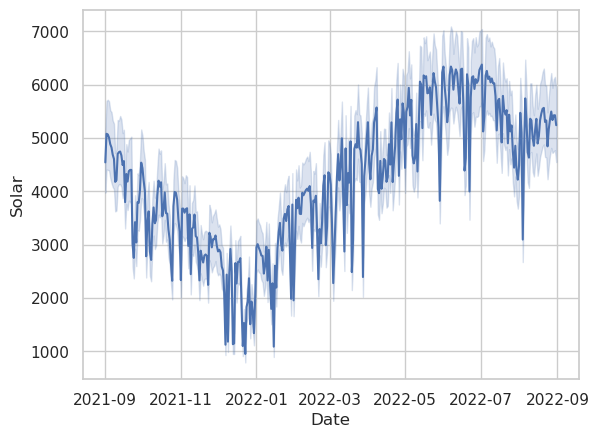

In [55]:
sns.lineplot(data=df, x='Date', y='Solar')

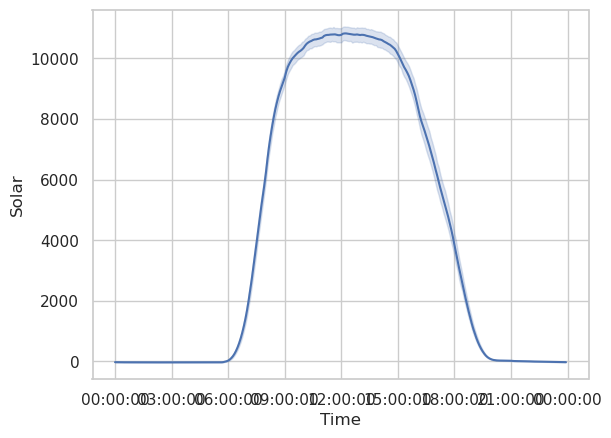

In [56]:
ax = sns.lineplot(data=df, x='Time', y='Solar')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

The curves are almost exactly what we should expect. The annual curve peaks in late June at the summer solstice, and has a trough in late December during the winter solstice. The light blue shaded region shows the 95% inner quantile range.

In order to make more plots easily with Seaborn, we need to convert the DataFrame from wide to long format.

In [57]:
df_long = df.drop(columns=['Unnamed: 0'])\
    .melt(id_vars=['Date', 'Time', 'DateTime', 'Month', 'Year'],
          var_name='Source',
          value_name='Power (MW)')
df_long

,Date,Time,DateTime,Month,Year,Source,Power (MW)
0,2021-09-01,2023-01-31 00:00:00,2021-09-01 00:00:00,9,2021,Solar,-34.0
1,2021-09-01,2023-01-31 00:05:00,2021-09-01 00:05:00,9,2021,Solar,-34.0
2,2021-09-01,2023-01-31 00:10:00,2021-09-01 00:10:00,9,2021,Solar,-34.0
3,2021-09-01,2023-01-31 00:15:00,2021-09-01 00:15:00,9,2021,Solar,-34.0
4,2021-09-01,2023-01-31 00:20:00,2021-09-01 00:20:00,9,2021,Solar,-34.0
...,...,...,...,...,...,...,...
1366347,2022-08-31,2023-01-31 23:35:00,2022-08-31 23:35:00,8,2022,Total power,32979.0
1366348,2022-08-31,2023-01-31 23:40:00,2022-08-31 23:40:00,8,2022,Total power,32855.0
1366349,2022-08-31,2023-01-31 23:45:00,2022-08-31 23:45:00,8,2022,Total power,32723.0
1366350,2022-08-31,2023-01-31 23:50:00,2022-08-31 23:50:00,8,2022,Total power,32670.0


Seaborn will order the line colors based on the order in which they show up in the DataFrame. This is fine, but I want them to be listed in the legend in the same order as they will appear visually on the plot.

In [58]:
argsort = df_long.groupby('Source').mean(numeric_only=True)['Power (MW)']\
            .argsort().values[::-1]
hue_order = np.array(
    df_long.groupby('Source').mean(numeric_only=True)\
        ['Power (MW)'][argsort].index
    )
# pal = np.concatenate(([[0,0,0]], np.array(sns.color_palette('Paired', len(hue_order)-1))))
pal = np.array(sns.color_palette('husl', len(hue_order)))[argsort]
pal[0] = np.array([0,0,0])

Next we'll make the same plots as above, but this time for all power sources. We can do this easily with the long-form DataFrame and Seaborn.

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


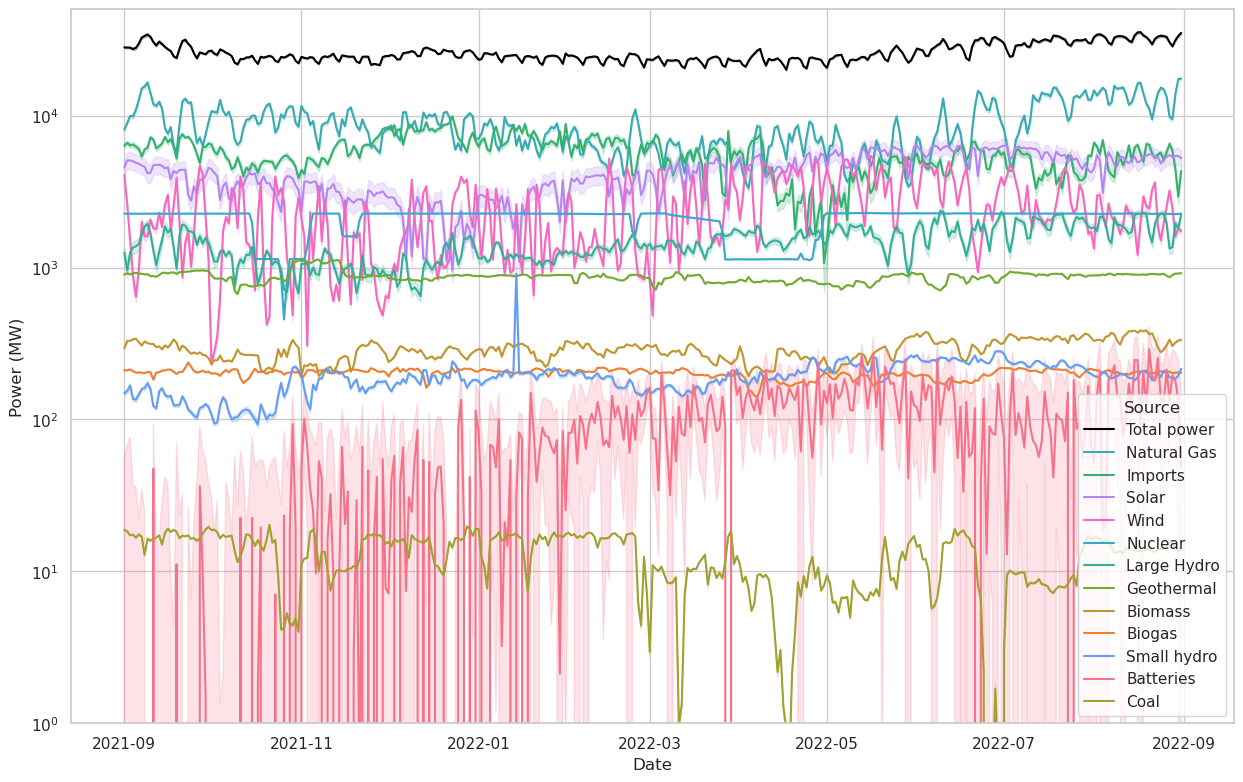

In [13]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Date',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
ax.set(yscale='log')
ax.set_ylim([1,5e4])
plt.show()

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


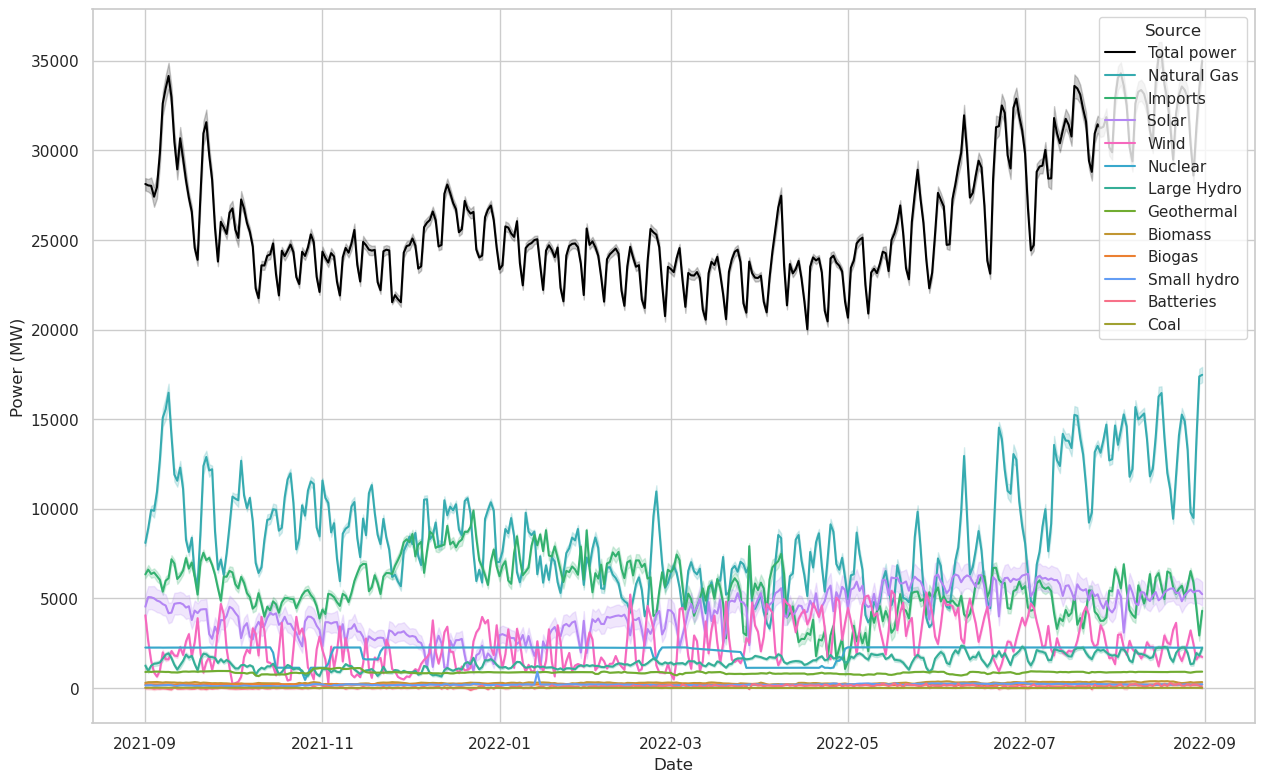

In [38]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Date',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
plt.show()

There are a number of interesting features happening in the two figures above.
- A weeklong variable period is apparent in the Total Power curve. January 1st 2022 was a Saturday and also lines up with one of the troughs, which indicates to me that weekends generally put substantially less load on the power system.
- In the linear plot, we can see that the Total Power drawn is generally higher in the summer and lower in the winter, although there is a notable increase in power draw around Christmastime. Christmas lights? Or perhaps it was just cold.
- Unsurprisingly, nuclear power output is generally extremely steady, although we can see that it did drop off a few times.
- We can again see the seasonal variability of solar power, probably more clearly in the linear plot than the log.
- On a day-to-day basis, wind power is extremely variable, more so than solar.
- California imports more power in the winter than summer. I would guess this may be because electricity gets more expensive in the summer, and therefore harder to import.
- Biomass, biogas, small hydro, and batteries play a pretty small role.
- There is virtually no coal power in the system. That's because there is only one 63 MW coal plant operating in the state of California, in Trona.

Now let's take a look at the hourly data.

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


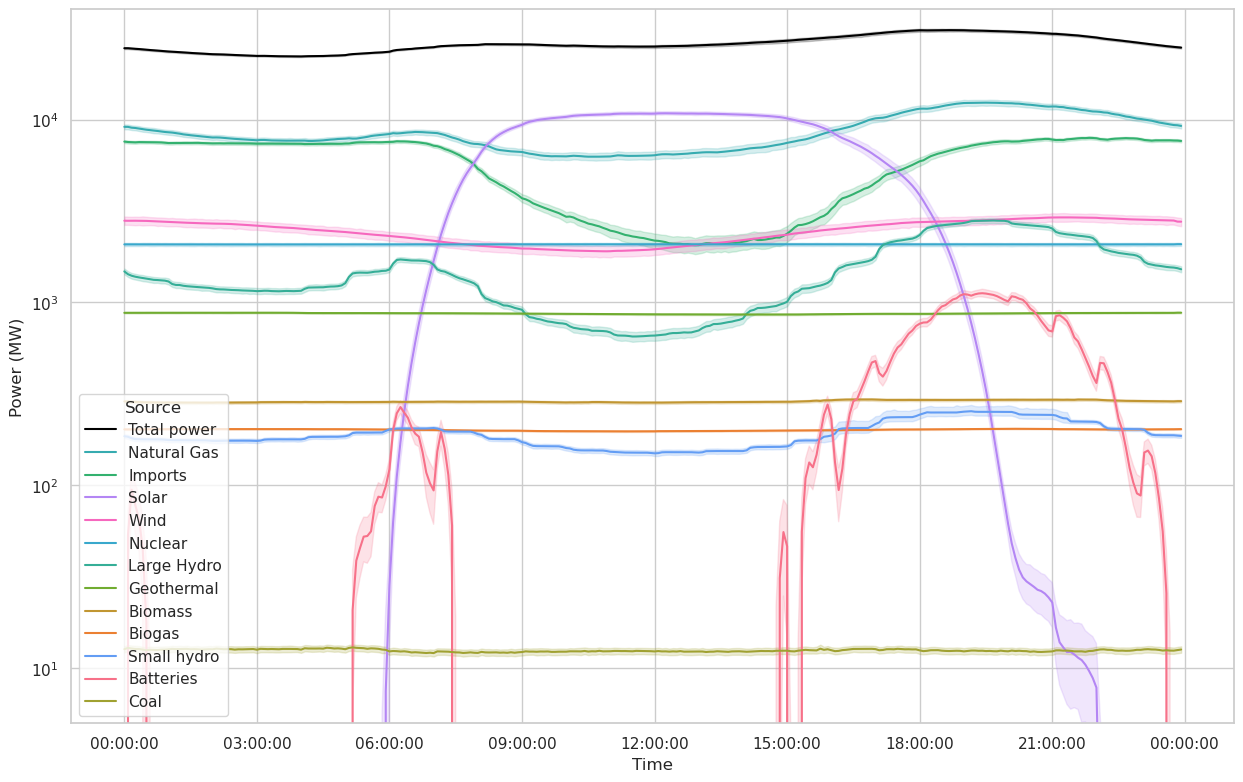

In [59]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Time',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
ax.set(yscale='log')
ax.set_ylim([5,4e4])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

/home/mbuuck/miniconda3/envs/caiso_analysis/lib/python3.11/site-packages/seaborn/_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


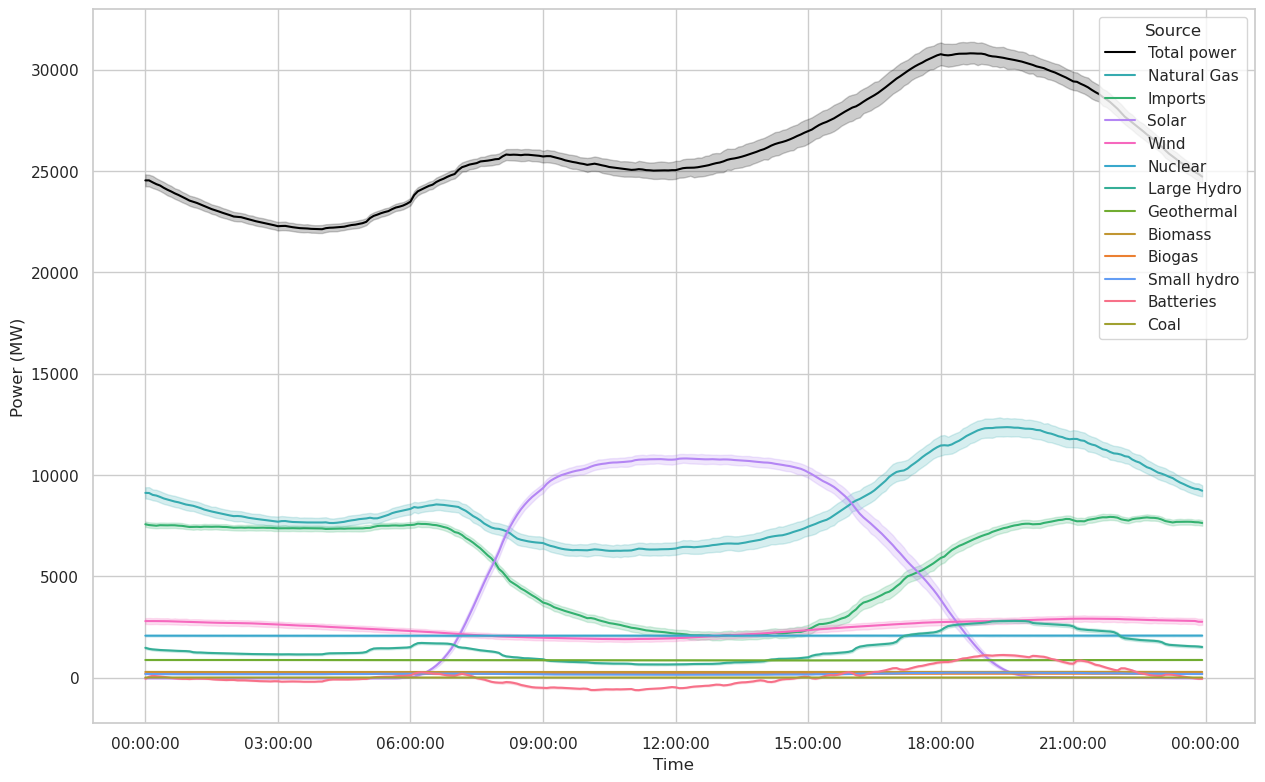

In [39]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(
    ax=ax,
    data=df_long,
    x='Time',
    y='Power (MW)',
    hue='Source',
    palette=pal,
    hue_order=hue_order
    )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.show()

Again we can make a few interesting observations.
- Although they make up only a small part of CAISO's power capacity, batteries are playing a nontrivial role at certain times of day, particularly in the evening. We can also see the batteries charging during the day in the linear plot (where the curve goes negative).
- The solar power curve has two "tails". I don't know what is causing them, but my hypothesis of what is has two components:
  - California is a long state N/S, and summer is the part of the year where the sun is up latest into the evening. During the summer, the evening terminator is mostly perpendicular to the length of the state, meaning that there should be a gradual dropoff in solar power as it gets dark from south to north. That explains the fact that there is at least one bump.
  - There are two bumps instead of one because of daylight savings time.
  - This does not occur in the morning because on summer mornings, the terminator faces the opposite direction and so all parts of the state start receiving solar power at about the same time.
- Wind power does indeed see variation complementary to solar power as advertised, but it is a much smaller source than solar and therefore is not able to offset much of the solar variability.

For the last plots in this section, I'm going to separate sources into dispatchable and non-dispatchable. Dispatchable resources are those that can be adjusted during the day to compensate for uncontrollable variability in other sources and demand. The dispatchable resources that vary during the day are:
- Natural Gas
- Imports
- Large Hydro
- Small Hydro
- Batteries
- (Theoretically coal would go here as well, but it's too small for me to see evidence of daily variation.)

In [60]:
df_long = df_long[df_long['Source']!='Total power']
dispatchable = ['Natural Gas', 'Imports', 'Large Hydro', 'Small Hydro', 'Batteries', 'Coal']
df_long['Dispatchable'] = df_long['Source'].apply(lambda x: x in dispatchable)

/tmp/ipykernel_373/424629375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['Variable'] = df_long['Source'].apply(lambda x: x in variable)
/tmp/ipykernel_373/424629375.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['Dispatchable'] = df_long['Source'].apply(lambda x: x in dispatchable)


In [74]:
df_dispatchable = df_long.groupby(by=['DateTime', 'Time', 'Date', 'Dispatchable']).sum()

/tmp/ipykernel_373/1789856550.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dispatchable = df_long.groupby(by=['DateTime', 'Time', 'Date', 'Dispatchable']).sum()


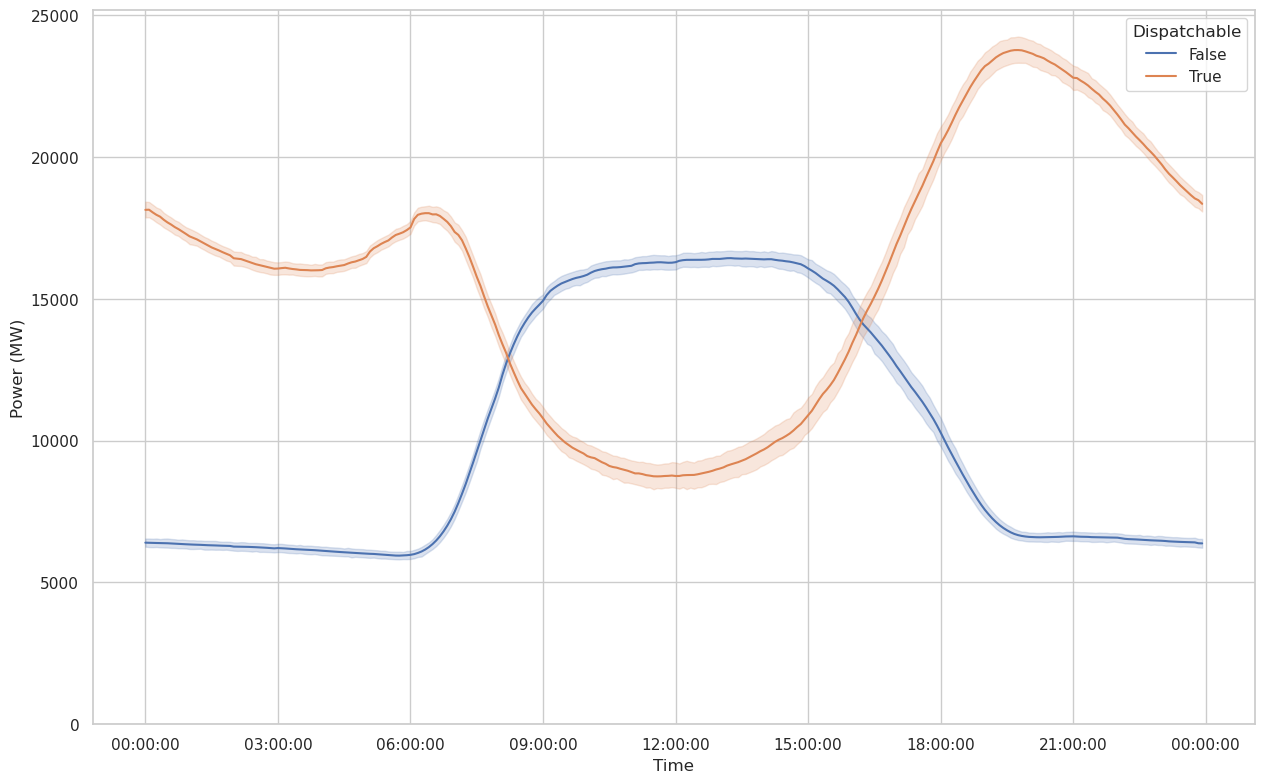

In [71]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(data=df_dispatchable, x='Time', y='Power (MW)', hue='Dispatchable')
ax.set_ylim([0, ax.get_ylim()[1]])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

(0.0, 26955.196124131944)

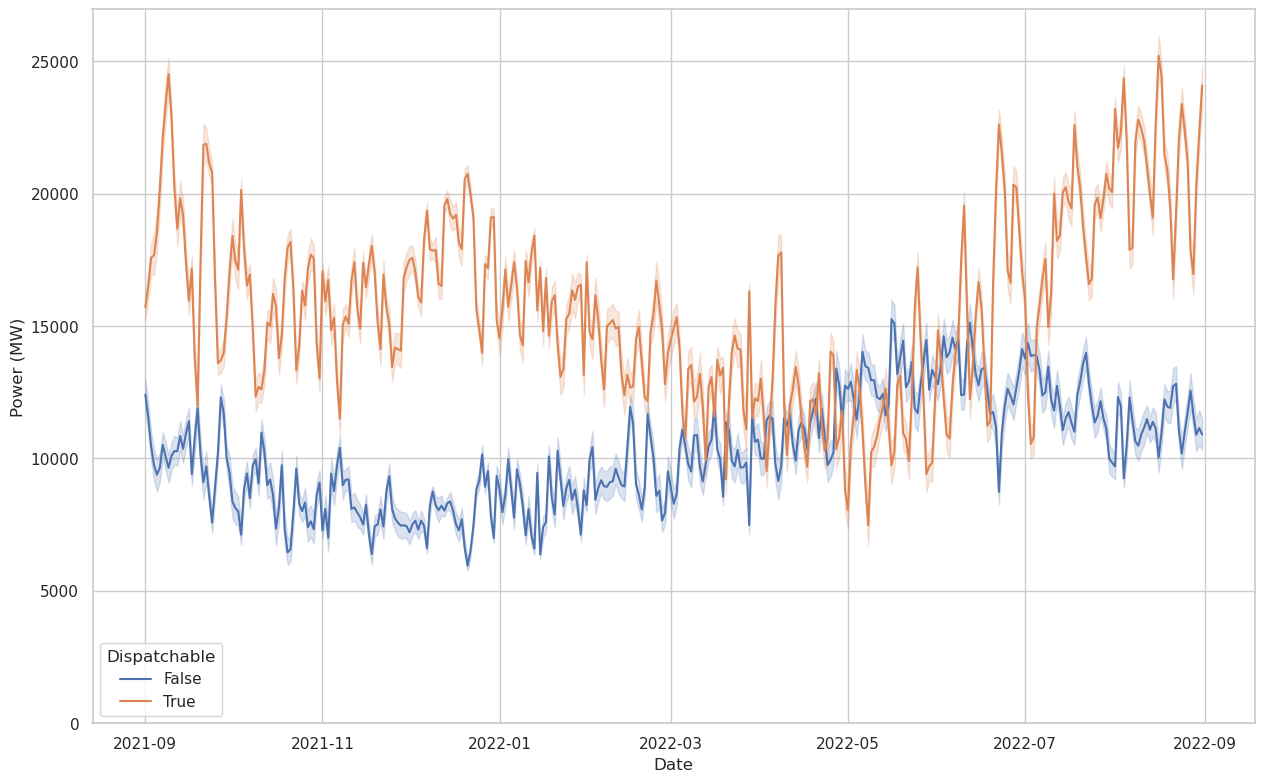

In [75]:
fig, ax = plt.subplots(figsize=(15,15/scipy.constants.golden))
ax = sns.lineplot(data=df_dispatchable, x='Date', y='Power (MW)', hue='Dispatchable')
ax.set_ylim([0, ax.get_ylim()[1]])

There's not quite as much to see here as in the previous plots, except that the duck curve is alive and well in the hourly plot. The daily plot is dominated by random variation and the seasonal variation of solar power.

## Time-series Modeling

Let's see if we can extract any utility (haha) from time-series analysis of this data. First we'll try an ARIMA analysis.

In [13]:
from statsmodels.tsa.arima.model import ARIMA

First let's just look at autocorrelations. Autocorrelation is the degree to which earlier observations are correlated with the current observation. They are expressed in terms of "lag"s, where a lag of 1 refers to the observation immediately prior to the current one, a lag of 2 refers to the observation 2 samples prior, and so on. Most processes (except for random walks) exhibit some autocorrelation, and the degree to which it dies away can characterize its noise profile.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

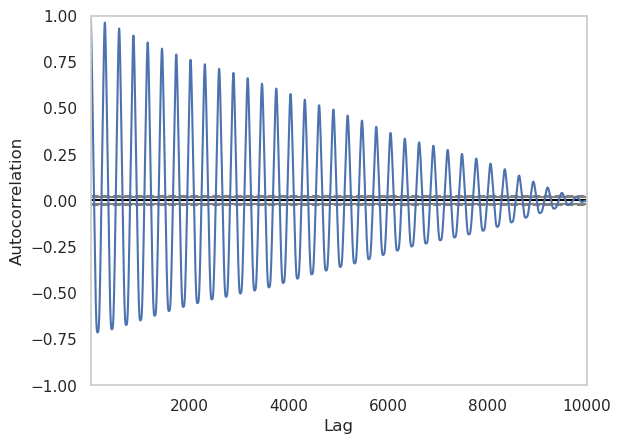

In [16]:
pd.plotting.autocorrelation_plot(df_long[df_long['Source']=='Solar']['Power (MW)'][:10000])

The solar power autocorrelation plot is not that interesting. We can see the daily variation though. Since the data is taken in 5-minute intervals, there are 288 observations in a single day. That is the period of the primary visible frequency. It dies away with time, which makes sense since the power output of a given solar panel should be more correlated with recent days, and less correlated with days further in the past.

Since natural gas is the single biggest source of power in CAISO's service area, let's see what its autocorrelation plot is like.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

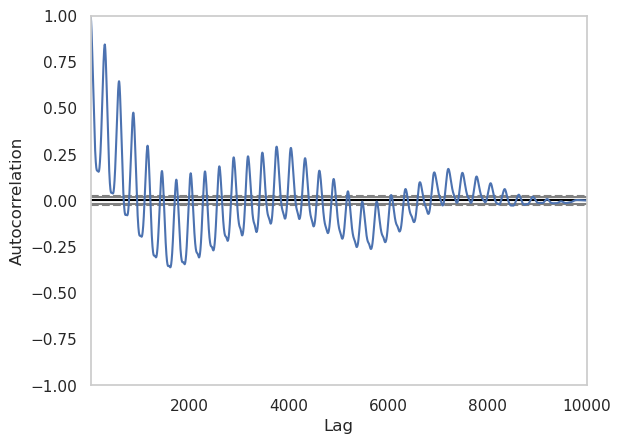

In [76]:
pd.plotting.autocorrelation_plot(df_long[df_long['Source']=='Natural Gas']['Power (MW)'][:10000])

I do not really understand some of the features of this figure, specifically the obvious variation with a ~13 day period (3744 lags). A weekly variation would not surprise me, since there is clearly an overall weekly variation in the total power consumption. But that does not appear to be what we see.